## Data Preparation

In [0]:
from __future__ import print_function, division
import os
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from astropy.io import fits

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
import torchvision
import torch.nn as nn
from torchvision import datasets, models, transforms
import time
import os
import copy


In [0]:
# First step, download data, it takes a few minutes....
! gsutil -m cp -r gs://massivenu/cosmological_parameters.txt .
! gsutil -m cp -r gs://massivenu/z1_256b .

Copying gs://massivenu/cosmological_parameters.txt...
/ [1/1 files][  3.2 KiB/  3.2 KiB] 100% Done                                    
Operation completed over 1 objects/3.2 KiB.                                      
Copying gs://massivenu/z1_256b/model002.tar.gz...
Copying gs://massivenu/z1_256b/model003.tar.gz...
Copying gs://massivenu/z1_256b/model001.tar.gz...
Copying gs://massivenu/z1_256b/model004.tar.gz...
Copying gs://massivenu/z1_256b/model006.tar.gz...
Copying gs://massivenu/z1_256b/model007.tar.gz...
Copying gs://massivenu/z1_256b/model008.tar.gz...
Copying gs://massivenu/z1_256b/model009.tar.gz...
Copying gs://massivenu/z1_256b/model005.tar.gz...
Copying gs://massivenu/z1_256b/model010.tar.gz...
Copying gs://massivenu/z1_256b/model011.tar.gz...
Copying gs://massivenu/z1_256b/model012.tar.gz...
Copying gs://massivenu/z1_256b/model013.tar.gz...
Copying gs://massivenu/z1_256b/model014.tar.gz...
Copying gs://massivenu/z1_256b/model015.tar.gz...
Copying gs://massivenu/z1_256b/mo

In [0]:
# Second step, extract data, that also takes a few minutes.... If anyone has a better way to do this....
! cd z1_256b ; for m in model*.tar.gz; do tar -xzf $m ; rm $m ; done; 

In [0]:
!cat cosmological_parameters.txt

#Model	M_nu(eV)	Omega_m	10^9*A_s	sigma_8(derived)
1	0.00000	0.3000	2.1000	0.8523
2	0.06271	0.3815	2.2004	1.0135
3	0.06522	0.2821	1.8826	0.7563
4	0.06773	0.4159	1.6231	0.9171
5	0.07024	0.2023	2.3075	0.6231
6	0.07275	0.3283	2.2883	0.9324
7	0.07526	0.3355	1.5659	0.7828
8	0.07778	0.2597	2.4333	0.8008
9	0.08030	0.2783	2.3824	0.8382
10	0.08282	0.2758	1.8292	0.7285
11	0.08535	0.3132	1.9913	0.8378
12	0.08788	0.2926	1.7376	0.7429
13	0.09041	0.2845	2.1757	0.8126
14	0.09295	0.3155	2.4949	0.9411
15	0.09550	0.3590	2.4624	1.0231
16	0.09805	0.3006	1.9744	0.8059
17	0.10061	0.2796	2.0161	0.7690
18	0.10318	0.3977	2.2607	1.0456
19	0.10575	0.3051	1.9117	0.8004
20	0.10833	0.2833	2.3595	0.8385
21	0.11092	0.3763	2.0404	0.9574
22	0.11351	0.1841	1.7932	0.4885
23	0.11612	0.3085	1.8056	0.7821
24	0.11874	0.3143	2.0079	0.8358
25	0.12136	0.3457	1.9483	0.8811
26	0.12400	0.3028	2.3174	0.8714
27	0.12665	0.2704	1.9658	0.7324
28	0.12931	0.2983	2.2342	0.8445
29	0.13198	0.2543	1.2886	0.5618
30	0.13467	0.3438	2.0324	0.8934

In [0]:
# Build PyTorch Dataset to read the fits files
class MassMapsDataset(Dataset):
    """Mass Maps Landmarks dataset."""

    def __init__(self, parameter_file, root_dir, transform=None):
        """
        Args:
            parameter_file (string): Path to the txt file with cosmological parameters.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
            ncosmo (int): Number of cosmologies to include in dataset
        """
        self.params = np.loadtxt(parameter_file)[1:]
        om = self.params[:,2]
        sigma8 = self.params[:,4]
        S8 = sigma8*(om/0.3)**0.5
        mask = (S8 > 0.8 - 0.075) & (S8 < 0.8 + 0.075)
        self.index = np.where(mask)[0]
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.index)*1000 # We have 1,000 realisations for each cosmology

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,'model%03d/WLconv_z1.00_%04dr.fits'%((self.index[idx % len(self.index)])+2, idx // len(self.index)))
        image = fits.getdata(img_name)

        params = self.params[self.index[idx % len(self.index)], [1, 2,-1]]
        
        sample = {'image': image, 'params': params}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [0]:
import torchvision.transforms.functional as F
import random

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, params = sample['image'], sample['params']
        if random.random() < 0.5:
            image = image[::-1]
        if random.random() < 0.5:
            image = image[:,::-1]
        if random.random() < 0.5:
            image = np.rot90(image)
        image = torch.from_numpy(image.reshape([1]+list(image.shape)).astype('float32'))
        params = torch.from_numpy(params.astype('float32'))
        image += torch.normal(image*0, image*0+0.001)
        return {'image': image,
                'params': params}

In [0]:
data_transform = transforms.Compose([
        ToTensor()
    ])

In [0]:
mnu_dataset = MassMapsDataset('cosmological_parameters.txt',  'z1_256b', transform=data_transform)

In [0]:
mnu_dataset.index.shape

(38,)

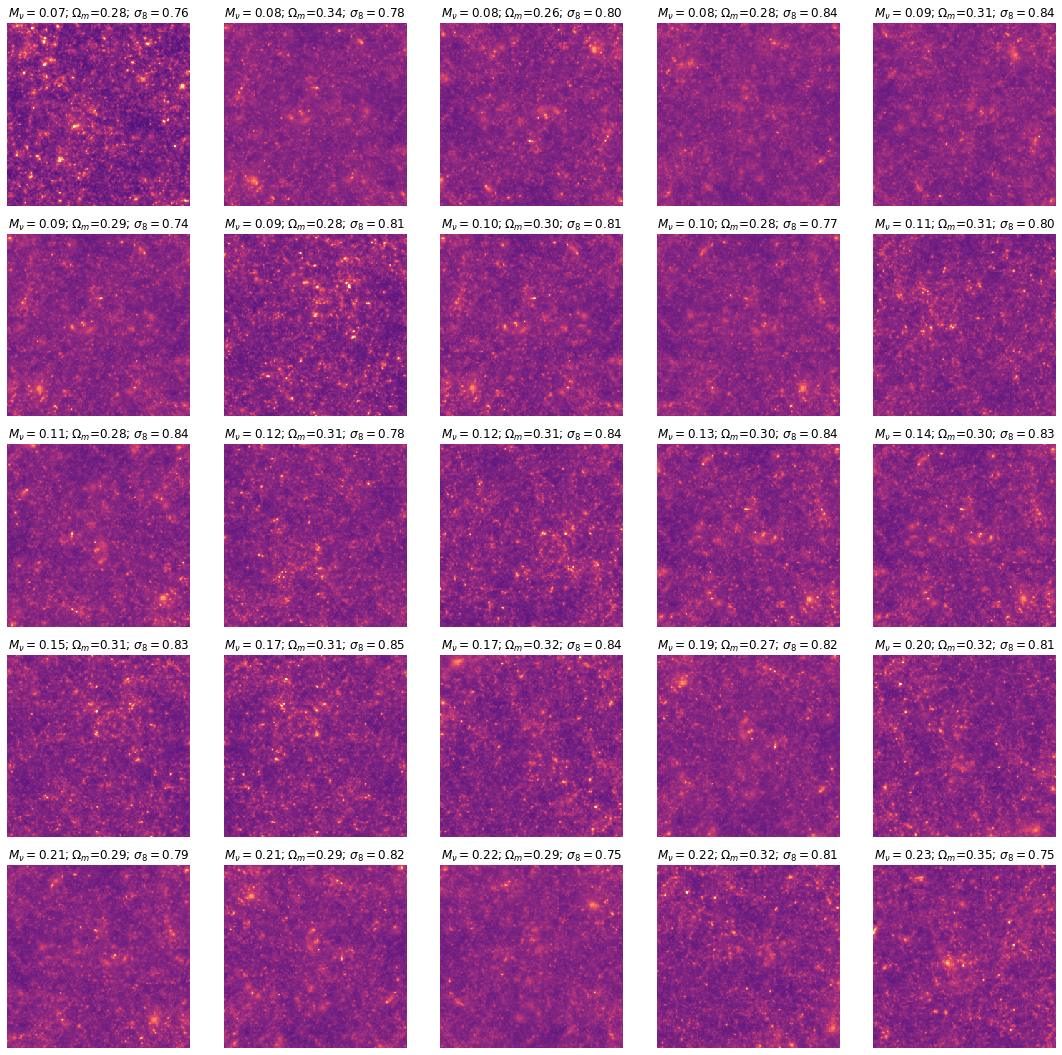

In [0]:
figure(figsize=(15,15))
mes = []
s8 = []
om = []
for i in range(len(mnu_dataset)):
    sample = mnu_dataset[i]
    #print(i, sample['image'].shape, sample['params'].shape)

    subplot(5, 5, i + 1)
    tight_layout()
    axis('off')
    imshow(squeeze(sample['image']), cmap='magma',vmin=-0.1,vmax=0.15)
    title(r"$M_\nu=%0.2f ; \Omega_m$=%0.2f; $\sigma_8=%0.2f$"%(sample['params'][0],sample['params'][1],sample['params'][2] ) )
    s8.append(sample['params'][2].numpy())
    om.append(sample['params'][1].numpy())
    mes.append(np.std(sample['image'].numpy()))
    if i == 24:
        break

In [0]:
sample['image'].shape

torch.Size([1, 256, 256])

## Train a model

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
model_ft = models.resnet18(pretrained=False)

In [0]:
# Modifying the model to predict the three cosmological parameters from single channel images
model_ft.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 3)
model_ft = model_ft.to(device)

In [0]:
data_transform = transforms.Compose([
        ToTensor()
    ])

In [0]:
mnu_dataset = MassMapsDataset('cosmological_parameters.txt',
                              'z1_256b', 
                              transform=data_transform)

dataloader = torch.utils.data.DataLoader(mnu_dataset, batch_size=128, 
                                         shuffle=True, num_workers=4)

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 0.0
    losses = []
    learning_rates= []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            
            # Iterate over data.
            for data in dataloader:
                inputs, params = data['image'], data['params']
                inputs = inputs.to(device)
                params = params.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, params)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                losses.append(loss.item())
            if phase == 'train':
                scheduler.step()
                learning_rates.append(scheduler.get_lr())

            epoch_loss = running_loss / len(mnu_dataset)
            
            print('{} Loss: {:.4f} '.format(
                phase, epoch_loss))

            # # deep copy the model
            # if phase == 'val' and epoch_loss < best_loss:
            #     best_loss = epoch_loss
            #     best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    # model.load_state_dict(best_model_wts)
    return model, losses, learning_rates

In [0]:
import torch.optim as optim
from torch.optim import lr_scheduler

criterion = torch.nn.L1Loss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

In [0]:
model_ft, loss_trace, lr_trace = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.0447 

Epoch 1/24
----------
train Loss: 0.0057 

Epoch 2/24
----------
train Loss: 0.0053 

Epoch 3/24
----------
train Loss: 0.0051 

Epoch 4/24
----------
train Loss: 0.0050 

Epoch 5/24
----------
train Loss: 0.0049 

Epoch 6/24
----------
train Loss: 0.0050 

Epoch 7/24
----------
train Loss: 0.0047 

Epoch 8/24
----------
train Loss: 0.0046 

Epoch 9/24
----------


KeyboardInterrupt: ignored

In [0]:
# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

In [0]:
model_ft, loss_trace2, lr_trace2 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.0323 

Epoch 1/24
----------
train Loss: 0.0318 

Epoch 2/24
----------
train Loss: 0.0317 

Epoch 3/24
----------
train Loss: 0.0315 

Epoch 4/24
----------
train Loss: 0.0314 

Epoch 5/24
----------
train Loss: 0.0310 

Epoch 6/24
----------
train Loss: 0.0308 

Epoch 7/24
----------
train Loss: 0.0307 

Epoch 8/24
----------
train Loss: 0.0306 

Epoch 9/24
----------
train Loss: 0.0304 

Epoch 10/24
----------
train Loss: 0.0287 

Epoch 11/24
----------
train Loss: 0.0284 

Epoch 12/24
----------
train Loss: 0.0284 

Epoch 13/24
----------


KeyboardInterrupt: ignored

In [0]:
plot(loss_trace2[100:])

In [0]:
plot(lr_trace2)
yscale('log')

In [0]:
with torch.no_grad():
  for data in dataloader:
    inputs, params = data['image'], data['params']
    inputs = inputs.to(device)
    params = params.to(device)
    outputs = model_ft(inputs)
    break

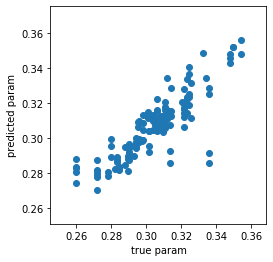

In [0]:
scatter(params.cpu()[:,1], outputs.cpu()[:,1])
xlabel('true param')
ylabel('predicted param')
#ylim(0.265,0.35)
#xlim(0.265,0.35)
gca().set_aspect('equal')

In [0]:
from sklearn.metrics import r2_score

coefficient_of_dermination = r2_score(params.cpu()[:,1], outputs.cpu()[:,1])

In [0]:
coefficient_of_dermination

0.7257992068325176

In [0]:
# Saving fairly well trained model
torch.save(model_ft.state_dict(), 'resnet18_state_dict')

In [0]:
torch.save(model_ft, 'resnet18')

In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
!gsutil cp resnet18* gs://massivenu/models_feb20/

Copying file://resnet18 [Content-Type=application/octet-stream]...
Copying file://resnet18_state_dict [Content-Type=application/octet-stream]...
\
Operation completed over 2 objects/85.4 MiB.                                     
